# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [36]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [37]:
# Use this space for any additional import statements you need

import nltk
from matplotlib import pyplot as plt


In [38]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions (referenced from module 2)
def descriptive_stats(tokens, num_tokens=5, verbose=True, min_frequency=10):
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
    and num_tokens most common tokens with a frequency greater than min_frequency. 
    Return a list with the number of tokens, number of unique tokens, lexical diversity, 
    and number of characters. 
    """
    
    # Calculate the number of tokens
    num_tokens = len(tokens)
    
    # Calculate the number of unique tokens
    num_unique_tokens = len(set(tokens))
    
    # Calculate the number of characters
    num_characters = sum(len(token) for token in tokens)
    
    # Calculate lexical diversity
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0
    
    # Find the most common tokens, filtering out non-alphabetic tokens and those with frequency <= min_frequency
    token_counts = Counter(token for token in tokens if token.isalpha())
    most_common_tokens = [(token, count) for token, count in token_counts.items() if count > min_frequency]
    
    # Sort the tokens by frequency in descending order
    most_common_tokens.sort(key=lambda x: x[1], reverse=True)
    
    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
        # Print the most common tokens with frequency > min_frequency
        print(f"The tokens with a frequency greater than {min_frequency} are:")
        for token, count in most_common_tokens:
            print(f"Token: '{token}' - Count: {count}")
    
    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]
    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text):
    """ Splitting on whitespace rather than the book's tokenize function.
        This function will preserve tokens like '#hashtag' or '2A', which we need for Twitter.
    """
    # Split the text on whitespace to get tokens
    tokens = text.split()
    return tokens

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [39]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [40]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [41]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [42]:
# read in the lyrics here

# Data path
data_location = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/"
lyrics_folder = os.path.join(data_location, "lyrics/")
artists = ["cher", "robyn"]

# Initialize the dictionary to store lyrics
lyrics_data = {}

# Read in the lyrics data
for artist in artists:
    artist_path = os.path.join(lyrics_folder, artist)
    lyrics_data[artist] = {}
    for song_file in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song_file)
        with open(song_path, 'r', encoding='utf-8') as file:
            lyrics_data[artist][song_file] = file.read()

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [44]:
# Define the pipeline
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Initialize the dictionary to store lyrics
lyrics_data = {}

# Read in the lyrics data
for artist in artists:
    artist_path = os.path.join(lyrics_folder, artist)
    lyrics_data[artist] = {}
    for song_file in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song_file)
        with open(song_path, 'r', encoding='utf-8') as file:
            lyrics_data[artist][song_file] = file.read()

# Process lyrics
for artist in lyrics_data:
    for song in lyrics_data[artist]:
        # Remove song titles (assuming the first line is the title)
        lyrics_data[artist][song] = "\n".join(lyrics_data[artist][song].split("\n")[1:])
        # Apply the pipeline
        lyrics_data[artist][song] = prepare(lyrics_data[artist][song], my_pipeline)

# Convert lyrics data to a DataFrame for further analysis
lyrics_df = pd.DataFrame([
    {"artist": artist, "song": song, "tokens": lyrics_data[artist][song]}
    for artist in lyrics_data for song in lyrics_data[artist]
])

# Add number of tokens column
lyrics_df["num_tokens"] = lyrics_df["tokens"].map(len)

In [45]:
# View output
lyrics_df.head()

,artist,song,tokens,num_tokens
0,cher,cher_comeandstaywithme.txt,"[ill, send, away, false, pride, ill, forsake, ...",76
1,cher,cher_pirate.txt,"[hell, sail, summer, wind, blows, day, everybo...",143
2,cher,cher_stars.txt,"[never, one, saying, really, feel, except, ton...",159
3,cher,cher_thesedays.txt,"[well, ive, walking, dont, much, talking, days...",81
4,cher,cher_lovesohigh.txt,"[every, morning, would, wake, id, tie, sun, ar...",87


In [46]:
# Define location of twitter files
data_location = '/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter'

# Initialize the dictionary to store Twitter descriptions
twitter_data = {}

# Read in the Twitter data
for twitter_file in os.listdir(data_location):
    #if twitter_file.endswith("_followers.txt") or twitter_file.startswith(".DS"):
     #   continue  # Skip files ending with "_followers.txt" and system files
    
    artist = twitter_file.split('_')[0]  # Extract artist name
    if artist not in twitter_data:
        twitter_data[artist] = []
    
    file_path = os.path.join(data_location, twitter_file)
    if os.path.getsize(file_path) == 0:
        print(f"Skipping empty file: {twitter_file}")
        continue
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            descriptions = file.readlines()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='latin-1') as file:
            descriptions = file.readlines()
    
    twitter_data[artist].extend([desc.strip() for desc in descriptions])

# Process Twitter descriptions
for artist in twitter_data:
    twitter_data[artist] = [prepare(desc, my_pipeline) for desc in twitter_data[artist]]

# Convert Twitter data to a DataFrame for further analysis
twitter_df = pd.DataFrame([
    {"artist": artist, "description": desc, "tokens": tokens}
    for artist in twitter_data for desc, tokens in zip(twitter_data[artist], twitter_data[artist])
])

# Add number of tokens column
twitter_df["num_tokens"] = twitter_df["tokens"].map(len)

In [54]:
# View output
twitter_df.head()

,artist,description,tokens,num_tokens,has_emoji
0,.DS,[   bud1                                  ...,[   bud1                                  ...,10,False
1,cher,"[screenname, name, id, location, followerscoun...","[screenname, name, id, location, followerscoun...",7,False
2,cher,"[hsmcnp, country, girl, 35152213, 1302, 1014]","[hsmcnp, country, girl, 35152213, 1302, 1014]",6,False
3,cher,"[horrormomy, jeny, 742153090850164742, earth, ...","[horrormomy, jeny, 742153090850164742, earth, ...",12,False
4,cher,"[anju79990584, anju, 1496463006451974150, 13, ...","[anju79990584, anju, 1496463006451974150, 13, ...",8,True


In [48]:
twitter_df['has_emoji'] = twitter_df["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [49]:
twitter_df[twitter_df.has_emoji].sample(10)[["artist","description","num_tokens"]]

,artist,description,num_tokens
169456,cher,"[badgalfilii1, 𝐹𝑖𝑙, 𝑡ℎ𝑒, 𝑣𝑎𝑚𝑝𝑖𝑟𝑒, 𝑠𝑙𝑎𝑦𝑒𝑟, 1391...",16
961662,cher,"[fzzylezzie, lisa, 94906877, ocean, view, de, ...",12
1176843,cher,"[beatlebaby4, lisa, brown, 274779627, toronto,...",18
291679,cher,"[jeankayou, johnkayou, 343042211, paris, franc...",8
912082,cher,"[archsorcerer, ícaro, 🧙🏽‍♂️, 🏳️‍🌈🇧🇷, 49150774,...",30
934729,cher,"[quelbeorlegui, shoot, moon, 2770623873, rio, ...",15
1113369,cher,"[valentinalavey, valentina, 😇, 895092523877543...",14
2795976,cher,"[eliem23, elie, mokbel, 763508202, 84, 1918, a...",9
1040784,cher,"[6hunni6bunni6, 🦷bunni, blue🦷, 301630528, hell...",17
1169302,cher,"[suxxx0nurbf, wh0r3had0wng, 944714339206000640...",15


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: For me it would be to see the entirety of the code as I would need to assume that the emoji is found in the cut off portion. While there were a few emojis found w/in the earlier portion of the description, the remaining seven are not known for sure. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [50]:
# your code here
# Function to calculate descriptive statistics
def calculate_descriptive_stats(df):
    num_tokens = df['num_tokens'].sum()
    num_songs = len(df)
    mean_tokens_per_song = df['num_tokens'].mean()
    median_tokens_per_song = df['num_tokens'].median()
    std_dev_tokens_per_song = df['num_tokens'].std()
    max_tokens_per_song = df['num_tokens'].max()
    min_tokens_per_song = df['num_tokens'].min()
    
    return {
        'Num Tokens': num_tokens,
        'Num Songs': num_songs,
        'Mean Tokens per Song': mean_tokens_per_song.round(1),
        'Median Tokens per Song': median_tokens_per_song.round(1),
        'Std Dev Tokens per Song': std_dev_tokens_per_song.round(1),
        'Max Tokens per Song': max_tokens_per_song,
        'Min Tokens per Song': min_tokens_per_song
    }

# Calculate descriptive statistics for each artist
stats_by_artist = {}
for artist in artists:
    artist_df = lyrics_df[lyrics_df['artist'] == artist]
    stats_by_artist[artist] = calculate_descriptive_stats(artist_df)

# Compare the results
for artist, stats in stats_by_artist.items():
    print(f"Statistics for {artist}:")
    for stat_name, value in stats.items():
        print(f"{stat_name}: {value}")
    print()

Statistics for cher:
Num Tokens: 35233
Num Songs: 316
Mean Tokens per Song: 111.5
Median Tokens per Song: 107.5
Std Dev Tokens per Song: 39.8
Max Tokens per Song: 240
Min Tokens per Song: 20

Statistics for robyn:
Num Tokens: 15041
Num Songs: 104
Mean Tokens per Song: 144.6
Median Tokens per Song: 136.0
Std Dev Tokens per Song: 67.5
Max Tokens per Song: 350
Min Tokens per Song: 8



Q: what observations do you make about these data? 

A: It appears that there is a greater fluctuation in total token in robyn songs w/ a mean of 144.6 +/- 67.5 while Cher is at an average of 111.5 +/- 39.8. The facinating portion to me is how Robyn managed to achieve a higher max tokens at 350 vs 240 for Cher and similarly a minimum token at 8 vs 20. While understanding that the mean is robust, the median also confirms that robyn still has more tokens in her songs. Being mindful of the difference in songs (316 cher vs 104 robyn), robyn has achieved 43% of the tokens of Cher with only 33% of the songs.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [51]:
# your code here

# Set the cutoff threshold
n = 5

# Function to calculate concentration ratio
def calculate_concentration_ratio(df, corpus_name):
    # Explode the 'tokens' column to convert lists into individual rows
    exploded_df = df.explode('tokens')
    
    total_tokens = exploded_df['num_tokens'].sum()
    corpus_tokens = exploded_df.groupby('tokens')['num_tokens'].sum()
    concentration = corpus_tokens / total_tokens
    return concentration.sort_values(ascending=False)


# Calculate concentration ratios/corpus
concentration_ratios = {}
for artist in artists:
    artist_df = lyrics_df[lyrics_df['artist'] == artist]
    concentration_ratios[artist] = calculate_concentration_ratio(artist_df, artist)

# Determine top 10 tokens/corpus
top_tokens_by_corpus = {}
for artist, concentration_ratio in concentration_ratios.items():
    top_tokens = concentration_ratio[concentration_ratio.index.map(lambda x: concentration_ratio[x] > n)].head(10)
    top_tokens_by_corpus[artist] = top_tokens if len(top_tokens) > 0 else concentration_ratio.head(10)

# Display results
for artist, top_tokens in top_tokens_by_corpus.items():
    print(f"Top tokens for {artist}:")
    print(top_tokens)
    print()


Top tokens for cher:
tokens
love     0.025688
im       0.015695
know     0.013645
dont     0.012290
baby     0.009564
youre    0.009273
time     0.009002
see      0.008955
take     0.008817
oh       0.008228
Name: num_tokens, dtype: float64

Top tokens for robyn:
tokens
know      0.021846
dont      0.018818
love      0.018132
im        0.018043
got       0.017665
like      0.015161
baby      0.013758
beat      0.011973
dance     0.011969
better    0.011894
Name: num_tokens, dtype: float64



Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: I found it interesting how there was an overlap in the top words between the artist including 'love', 'im','know', 'dont', and 'baby'. While the frequency based of the two artist vary, most of them are still w/in the top five tokens. The token love is not of much surprise, but I did find 'know' and 'dont' pretty unique. Robyn did have a small variance of the ratio of the top tokens especially when compared to Cher. My initial inclination would be to look at the tokens found in similar singles of the same genre of music. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


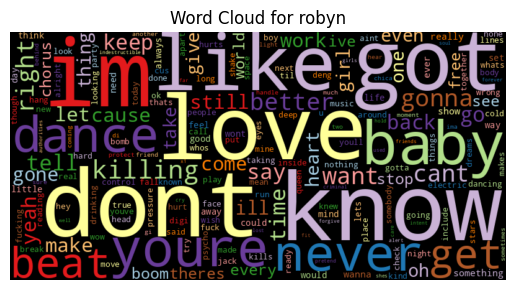

In [52]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter & run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

# Generate word clouds & count word frequency for each artist
for artist in artists:
    artist_df = lyrics_df[lyrics_df['artist'] == artist]
    
    # Word frequency
    word_freq = count_words(artist_df)
    
    # Convert word frequency Series into dictionary
    word_freq_dict = word_freq.to_dict()['freq']
    
    # Generate word cloud
    wordcloud(word_freq_dict, title=f"Word Cloud for {artist}")

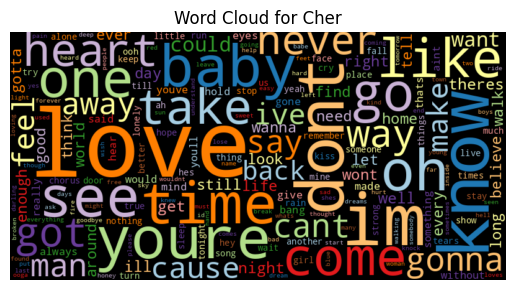

In [53]:
# Select Cher's lyrics data as it didn't want to prompt in loop
cher_df = lyrics_df[lyrics_df['artist'] == 'cher']

# Generate word freq.
word_freq_cher = count_words(cher_df)

# Convert word frequency Series into dictionary
word_freq_dict_cher = word_freq_cher.to_dict()['freq']

# Generate word cloud
wordcloud(word_freq_dict_cher, title="Word Cloud for Cher")


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word cloud plots are an effective tool to display the most prevalent tokens found in the artist songs. While the previous chunk of code only displayed the top 10 tokens, this displays a relative comparison for each artist. This is also a good way to see similar token frequency or usage for the development of future lyrics. 